<a href="https://colab.research.google.com/github/Piyush42Soni/Share_Price_Predictor_App/blob/master/SharePricePredictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
keras = tf.keras

In [14]:
def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)
  

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)




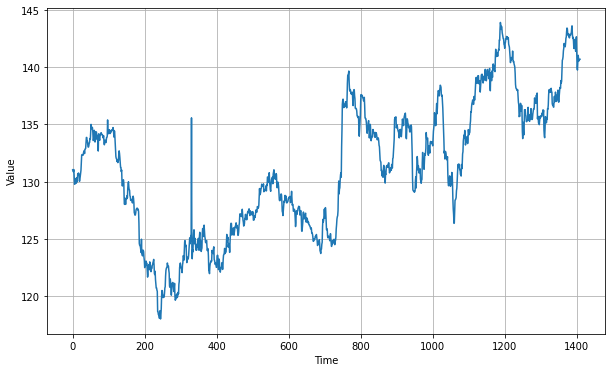

In [15]:
series1 = (pd.read_csv("/content/drive/MyDrive/extended_intraday_IBM_60min_year1month1_adjusted.csv"))
series=((series1['high']+series1['low'])/2).to_numpy()
series=series[::-1]
time = np.arange(len(series))
plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [16]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [17]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
print(train_set)
model = keras.models.Sequential([
  keras.layers.Conv1D(filters=150, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(150, return_sequences=True),
  keras.layers.LSTM(150, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>
Epoch 1/100
8/8 [==============================] - 3s 19ms/step - loss: 106.8666 - mae: 107.3666 - lr: 1.0000e-08
Epoch 2/100
8/8 [==============================] - 0s 16ms/step - loss: 100.7426 - mae: 101.2426 - lr: 1.1220e-08
Epoch 3/100
8/8 [==============================] - 0s 16ms/step - loss: 82.6467 - mae: 83.1467 - lr: 1.2589e-08
Epoch 4/100
8/8 [==============================] - 0s 15ms/step - loss: 65.3472 - mae: 65.8472 - lr: 1.4125e-08
Epoch 5/100
8/8 [==============================] - 0s 16ms/step - loss: 54.2857 - mae: 54.7857 - lr: 1.5849e-08
Epoch 6/100
8/8 [==============================] - 0s 16ms/step - loss: 43.4126 - mae: 43.9124 - lr: 1.7783e-08
Epoch 7/100
8/8 [==============================] - 0s 16ms/step - loss: 34.0639 - mae: 34.5558 - lr: 1.9953e-08
Epoch 8/100
8/8 [==============================] - 0

(1e-08, 0.0001, 0.0, 30.0)

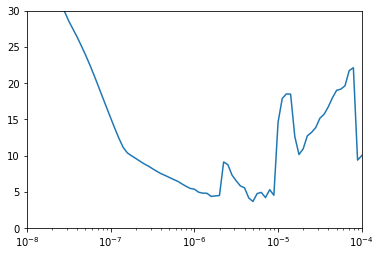

In [18]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [19]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.Conv1D(filters=150, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(150, return_sequences=True),
  keras.layers.LSTM(150, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
optimizer = keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
8/8 [==============================] - 4s 162ms/step - loss: 62.4085 - mae: 62.9077 - val_loss: 35.2776 - val_mae: 35.7762
Epoch 2/500
8/8 [==============================] - 1s 71ms/step - loss: 33.5852 - mae: 34.0827 - val_loss: 28.5081 - val_mae: 29.0081
Epoch 3/500
8/8 [==============================] - 1s 60ms/step - loss: 18.6215 - mae: 19.1172 - val_loss: 11.0166 - val_mae: 11.4916
Epoch 4/500
8/8 [==============================] - 1s 43ms/step - loss: 12.2446 - mae: 12.7337 - val_loss: 13.6324 - val_mae: 14.1283
Epoch 5/500
8/8 [==============================] - 1s 56ms/step - loss: 9.5107 - mae: 9.9959 - val_loss: 16.3828 - val_mae: 16.8813
Epoch 6/500
8/8 [==============================] - 1s 52ms/step - loss: 8.4583 - mae: 8.9416 - val_loss: 13.7189 - val_mae: 14.2167
Epoch 7/500
8/8 [==============================] - 1s 65ms/step - loss: 7.8337 - mae: 8.3131 - val_loss: 11.8452 - val_mae: 12.3387
Epoch 8/500
8/8 [==============================] - 1s 42ms/step - l

In [20]:
model = keras.models.load_model("my_checkpoint.h5")

In [21]:
rnn_forecast = model_forecast(model, series[:,  np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]
model.save("ModelSaved1.h5")
import tensorflow as tf

model = tf.keras.models.load_model('my_checkpoint.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [
        tf.lite.OpsSet.TFLITE_BUILTINS,  
        tf.lite.OpsSet.SELECT_TF_OPS  
    ]
converter.experimental_enable_resource_variables = True
tflite_model = converter.convert()
open("converted_model1.tflite", "wb").write(tflite_model)

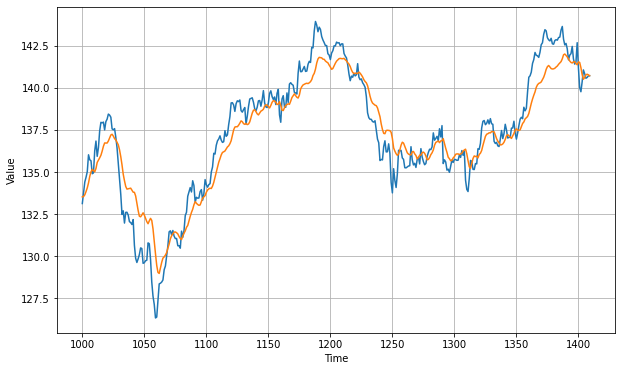

In [22]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [23]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

0.98357666